# **XG Boost Model including Engineered Features/Dimensional Reduction**

**Business problem:** Train a binary classification model to accurately predict if an NBA rookie player will have a career that will last at least 5 years in the league.

## **Pre-processing**

### **Load Packages**

In [1]:
# File management
import os

# Data/numeric manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Modelling
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance

### **Load Data**

In [2]:
# Create data directory
if not os.path.exists('/content/kaggle'):
    os.makedirs('/content/kaggle')
    
# Create output directory
if not os.path.exists('/content/output'):
    os.makedirs('/content/output')

# Download data from Kaggle API, unzip and place in data directory
os.environ['KAGGLE_USERNAME'] = "kallikrates"
os.environ['KAGGLE_KEY'] = "6ec6a025503be3d3b75961c4c2ac2748"
!kaggle datasets download -d kallikrates/nba-career-prediction-data
!unzip -q nba-career-prediction-data.zip -d /content/kaggle

  0% 0.00/367k [00:00<?, ?B/s]
100% 367k/367k [00:00<00:00, 49.5MB/s]


In [3]:
#Create data objects
train_data = pd.read_csv('/content/kaggle/train.csv')
test_data = pd.read_csv('/content/kaggle/test.csv')

### **Check Data**

#### **View/Summarise Data**

Check to ensure all data types look right - i.e. numeric.

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id_old       8000 non-null   int64  
 1   Id           8000 non-null   int64  
 2   GP           8000 non-null   int64  
 3   MIN          8000 non-null   float64
 4   PTS          8000 non-null   float64
 5   FGM          8000 non-null   float64
 6   FGA          8000 non-null   float64
 7   FG%          8000 non-null   float64
 8   3P Made      8000 non-null   float64
 9   3PA          8000 non-null   float64
 10  3P%          8000 non-null   float64
 11  FTM          8000 non-null   float64
 12  FTA          8000 non-null   float64
 13  FT%          8000 non-null   float64
 14  OREB         8000 non-null   float64
 15  DREB         8000 non-null   float64
 16  REB          8000 non-null   float64
 17  AST          8000 non-null   float64
 18  STL          8000 non-null   float64
 19  BLK   

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799 entries, 0 to 3798
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id_old   3799 non-null   int64  
 1   Id       3799 non-null   int64  
 2   GP       3799 non-null   int64  
 3   MIN      3799 non-null   float64
 4   PTS      3799 non-null   float64
 5   FGM      3799 non-null   float64
 6   FGA      3799 non-null   float64
 7   FG%      3799 non-null   float64
 8   3P Made  3799 non-null   float64
 9   3PA      3799 non-null   float64
 10  3P%      3799 non-null   float64
 11  FTM      3799 non-null   float64
 12  FTA      3799 non-null   float64
 13  FT%      3799 non-null   float64
 14  OREB     3799 non-null   float64
 15  DREB     3799 non-null   float64
 16  REB      3799 non-null   float64
 17  AST      3799 non-null   float64
 18  STL      3799 non-null   float64
 19  BLK      3799 non-null   float64
 20  TOV      3799 non-null   float64
dtypes: float64(18)

Check part of the data in raw and summarised form to spot anomalies.

In [6]:
train_data.head()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


In [7]:
test_data.head()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,1,0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,8194,1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,3,2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,8196,3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,8197,4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9


In [8]:
train_data.describe()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,6856.971000,7798.50000,62.777875,18.576663,7.267087,2.807037,6.231213,44.608900,0.264525,0.816563,19.583700,1.392525,1.947787,71.365825,1.077838,2.168500,3.245300,1.624513,0.648688,0.245212,1.257762,0.833625
std,3977.447579,2309.54541,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,16.003155,0.926153,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,4.000000,3799.00000,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,-38.500000,0.000000,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,3413.750000,5798.75000,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,8.400000,0.700000,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,6787.500000,7798.50000,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,19.500000,1.200000,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,10299.250000,9798.25000,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,30.600000,1.900000,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,13798.000000,11798.00000,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,82.100000,8.100000,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [9]:
test_data.describe()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
count,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000
mean,7010.614109,1899.000000,62.853909,18.650224,7.328034,2.835404,6.302580,44.599079,0.255962,0.796920,19.234746,1.399842,1.953567,71.612924,1.096025,2.179495,3.275783,1.636483,0.653593,0.257726,1.257910
std,3954.173641,1096.821164,17.151740,8.727259,4.294724,1.688427,3.579221,6.040168,0.380987,1.052862,15.968989,0.926140,1.250376,10.457336,0.785678,1.371935,2.070646,1.335496,0.410573,0.639660,0.712449
min,1.000000,0.000000,6.000000,3.700000,0.700000,0.300000,0.800000,25.100000,-1.000000,-2.700000,-38.000000,0.000000,0.000000,23.700000,0.000000,0.200000,0.300000,0.000000,0.000000,-7.100000,0.100000
25%,3644.000000,949.500000,51.000000,12.200000,4.200000,1.600000,3.700000,40.500000,0.000000,0.100000,8.500000,0.700000,1.000000,65.000000,0.500000,1.200000,1.800000,0.600000,0.400000,0.100000,0.700000
50%,7062.000000,1899.000000,63.000000,17.000000,6.400000,2.500000,5.500000,44.600000,0.300000,0.800000,19.400000,1.200000,1.700000,71.500000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000
75%,10402.500000,2848.500000,74.000000,23.300000,9.400000,3.700000,8.100000,48.500000,0.500000,1.500000,30.250000,1.900000,2.600000,78.000000,1.500000,2.900000,4.300000,2.300000,0.900000,0.400000,1.600000
max,13792.000000,3798.000000,126.000000,68.000000,33.000000,13.400000,26.200000,74.600000,1.600000,4.300000,73.800000,7.800000,9.800000,127.100000,6.900000,12.000000,18.500000,9.000000,2.700000,14.800000,5.200000


#### **Check for Whitespace in Column Names**

Check for whitespaces in column names and replace with '_' where they exist. Helps with drawing trees and other visualisations.

In [10]:
train_data.columns = train_data.columns.str.replace(' ','_')
test_data.columns = test_data.columns.str.replace(' ','_')

#### **Check for Missing Values**

Check for missing values and replace with 0 where they are found.

In [11]:
# Check for NULL values in train data
train_data.isnull().sum()

Id_old         0
Id             0
GP             0
MIN            0
PTS            0
FGM            0
FGA            0
FG%            0
3P_Made        0
3PA            0
3P%            0
FTM            0
FTA            0
FT%            0
OREB           0
DREB           0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
dtype: int64

In [12]:
# Check for NULL values in test data
test_data.isnull().sum()

Id_old     0
Id         0
GP         0
MIN        0
PTS        0
FGM        0
FGA        0
FG%        0
3P_Made    0
3PA        0
3P%        0
FTM        0
FTA        0
FT%        0
OREB       0
DREB       0
REB        0
AST        0
STL        0
BLK        0
TOV        0
dtype: int64

#### **Target Variable Balance Check**

Check distribution of target variable. It appears unbalanced, but within the context (NBA players still in the league), reasonable. I will not treat it as an issue at this point.

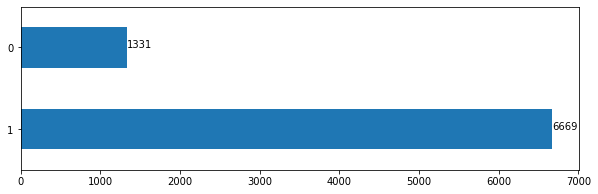

In [13]:
# Check distribution balance of target variable
y = train_data.TARGET_5Yrs.value_counts()
fig= plt.figure(figsize=(10,3))
train_data.TARGET_5Yrs.value_counts().plot(kind='barh')
for index, value in enumerate(y):
    plt.text(value, index, str(value))
plt.show()

### **Variable Correlation**

In [14]:
pearson_corr = train_data.corr(method ='pearson')
pearson_corr.style.background_gradient(cmap='coolwarm', axis=None)

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P_Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
Id_old,1.000000,-0.010224,0.028860,0.027481,0.023416,0.023845,0.024341,0.009777,0.008947,0.009524,-0.005559,0.020854,0.017460,0.018887,0.014007,0.018180,0.018471,0.017703,0.007974,0.011955,0.021505,0.018233
Id,-0.010224,1.000000,0.003940,-0.002747,0.003048,0.001812,0.000376,0.010359,-0.009092,-0.005847,-0.001710,0.008232,0.008845,-0.003565,-0.004322,-0.004517,-0.004924,0.008069,0.013752,-0.005705,0.013185,0.006645
GP,0.028860,0.003940,1.000000,0.608090,0.578344,0.577697,0.553374,0.278510,0.123231,0.119146,0.045434,0.524276,0.519154,0.155667,0.402654,0.492070,0.484485,0.402126,0.473409,0.187269,0.537821,0.242108
MIN,0.027481,-0.002747,0.608090,1.000000,0.904840,0.895957,0.895085,0.234919,0.358597,0.372454,0.153846,0.767647,0.753660,0.212366,0.542782,0.770128,0.728842,0.639013,0.759933,0.260428,0.792059,0.182203
PTS,0.023416,0.003048,0.578344,0.904840,1.000000,0.989208,0.973297,0.301991,0.337786,0.349452,0.156044,0.864463,0.842903,0.257157,0.539289,0.690687,0.673621,0.573893,0.678514,0.232923,0.816414,0.182004
FGM,0.023845,0.001812,0.577697,0.895957,0.989208,1.000000,0.972670,0.343140,0.288906,0.299300,0.123230,0.810273,0.798366,0.208038,0.565086,0.699456,0.689229,0.550682,0.663419,0.245199,0.799119,0.183568
FGA,0.024341,0.000376,0.553374,0.895085,0.973297,0.972670,1.000000,0.140998,0.373362,0.399025,0.203040,0.787989,0.761174,0.263515,0.464325,0.635072,0.607930,0.619597,0.689391,0.191895,0.816810,0.162389
FG%,0.009777,0.010359,0.278510,0.234919,0.301991,0.343140,0.140998,1.000000,-0.269994,-0.330586,-0.312446,0.279252,0.335512,-0.187200,0.539317,0.429142,0.490902,-0.132006,0.071364,0.288155,0.128622,0.158858
3P_Made,0.008947,-0.009092,0.123231,0.358597,0.337786,0.288906,0.373362,-0.269994,1.000000,0.979340,0.585280,0.149567,0.088516,0.320845,-0.200575,0.076694,-0.014098,0.375967,0.305817,-0.094750,0.231413,0.015016
3PA,0.009524,-0.005847,0.119146,0.372454,0.349452,0.299300,0.399025,-0.330586,0.979340,1.000000,0.576168,0.165116,0.101186,0.335011,-0.213506,0.069782,-0.023208,0.409646,0.337407,-0.101143,0.255422,0.003463


## **Experiment 1:Feature Reduction and Supplementation**

In this expetiment, it is assumed that taking/adding variables may add to the predictive power of the model. This will be tested by various means (reduce variables, add calculated variables).

**Objective:**

Feature Reduction: Use analysis of the variables and feature importance XG Boost model function to reduce variables. Compare score with baseline model, including full set.

Feature Supplementation: Add two calculated variables TOV% (Turnover Percentage) and PPG (Points per game) and compare score to baseline. Check feature importance.


#### **Plot Feature Importance**

First, the model will be run to plot feature importance using 

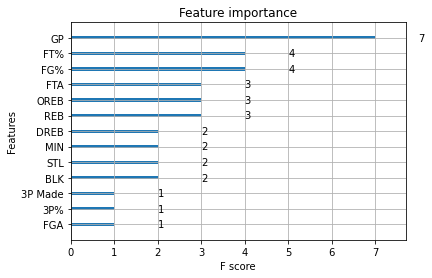

0.7223609643646144

In [15]:
train_data = pd.read_csv('/content/kaggle/train.csv')
test_data = pd.read_csv('/content/kaggle/test.csv')

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)

X_data, X_test, y_data, y_test = train_test_split(df_train_scaled, train_data_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

xgb_clf = XGBClassifier(n_estimators=20, 
                            learning_rate=0.9, 
                            max_features=2, 
                            max_depth=2, 
                            random_state=42)
xgb_clf.fit(X_train, y_train)

xgb_clf = XGBClassifier(learning_rate=0.9,
                        n_estimators=300,
                        max_depth=4,
                        colsample_bynode=1,
                        gamma=8,
                        max_delta_step=1,
                        min_child_weight=1, 
                        missing=None, 
                        n_jobs=1,
                        nthread=None, 
                        objective='binary:logistic', 
                        random_state=42,
                        reg_alpha=0, 
                        reg_lambda=0, 
                        scale_pos_weight=1, 
                        seed=None,
                        silent=None, subsample=1, verbosity=1)

xgb_clf.fit(X_train, y_train)

plot_importance(xgb_clf)
plt.show()
roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])

##### **Check for Valid Target variable values**

Check to ensure target valuesvariable values are only 1 and 0. 

In [16]:
y_data.unique()

array([1, 0])

### **Dimensionality Reduction**

The following tests are to show the value of removing explanatory variables to reduce dimensionality.

#### **Remove Variables that are Constituents of Other Variables**

In [17]:
train_data = pd.read_csv('/content/kaggle/train.csv')
test_data = pd.read_csv('/content/kaggle/test.csv')

# Remove constituent variables

train_data.drop(['3P Made', '3PA', 'FGA', 'FGM','FTA', 'FTM'], axis=1, inplace=True)
test_data.drop(['3P Made', '3PA', 'FGA', 'FGM','FTA', 'FTM'], axis=1, inplace=True)

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)

X_data, X_test, y_data, y_test = train_test_split(df_train_scaled, train_data_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

xgb_clf = XGBClassifier(n_estimators=20, 
                            learning_rate=0.9, 
                            max_features=2, 
                            max_depth=2, 
                            random_state=42)
xgb_clf.fit(X_train, y_train)

xgb_clf = XGBClassifier(learning_rate=0.9,
                        n_estimators=300,
                        max_depth=4,
                        colsample_bynode=1,
                        gamma=8,
                        max_delta_step=1,
                        min_child_weight=1, 
                        missing=None, 
                        n_jobs=1,
                        nthread=None, 
                        objective='binary:logistic', 
                        random_state=42,
                        reg_alpha=0, 
                        reg_lambda=0, 
                        scale_pos_weight=1, 
                        seed=None,
                        silent=None, subsample=1, verbosity=1)

xgb_clf.fit(X_train, y_train)

roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])

0.7163531246712498

**Result:** Score drops slightly (-0.6%). Also tried individually for each variable and there is no improvement. 

**Conclusion:** Taking away less constituent variables does not add predictive value.

#### **Remove Variables that are Low in Importance**

In [18]:
train_data = pd.read_csv('/content/kaggle/train.csv')
test_data = pd.read_csv('/content/kaggle/test.csv')

# Remove constituent variables

train_data.drop(['3P Made', '3P%', 'FGA'], axis=1, inplace=True)
test_data.drop(['3P Made', '3P%', 'FGA'], axis=1, inplace=True)

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)

X_data, X_test, y_data, y_test = train_test_split(df_train_scaled, train_data_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

xgb_clf = XGBClassifier(n_estimators=20, 
                            learning_rate=0.9, 
                            max_features=2, 
                            max_depth=2, 
                            random_state=42)
xgb_clf.fit(X_train, y_train)

xgb_clf = XGBClassifier(learning_rate=0.9,
                        n_estimators=300,
                        max_depth=4,
                        colsample_bynode=1,
                        gamma=8,
                        max_delta_step=1,
                        min_child_weight=1, 
                        missing=None, 
                        n_jobs=1,
                        nthread=None, 
                        objective='binary:logistic', 
                        random_state=42,
                        reg_alpha=0, 
                        reg_lambda=0, 
                        scale_pos_weight=1, 
                        seed=None,
                        silent=None, subsample=1, verbosity=1)

xgb_clf.fit(X_train, y_train)

roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])

0.7086803792691796

**Result:** Score drops slightly (-1.37%). Also tried individually for each variable and there is no improvement. 

**Conclusion:** Taking away less important variables does not add predictive value.

### **Dimensionality Supplement**

The following tests are to show the value of adding two calculated variables: TOV% and PPG.

In [19]:
train_data = pd.read_csv('/content/kaggle/train.csv')
test_data = pd.read_csv('/content/kaggle/test.csv')

# Add Calculated Variables

# train_data['PPG'] = (train_data['PTS']/train_data['GP'])
train_data['TOV%'] = (100*train_data['TOV']/(train_data['FGA']+0.44*train_data['FTA']+train_data['TOV']))

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)

X_data, X_test, y_data, y_test = train_test_split(df_train_scaled, train_data_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

xgb_clf = XGBClassifier(n_estimators=20, 
                            learning_rate=0.9, 
                            max_features=2, 
                            max_depth=2, 
                            random_state=42)
xgb_clf.fit(X_train, y_train)

xgb_clf = XGBClassifier(learning_rate=0.9,
                        n_estimators=300,
                        max_depth=4,
                        colsample_bynode=1,
                        gamma=8,
                        max_delta_step=1,
                        min_child_weight=1, 
                        missing=None, 
                        n_jobs=1,
                        nthread=None, 
                        objective='binary:logistic', 
                        random_state=42,
                        reg_alpha=0, 
                        reg_lambda=0, 
                        scale_pos_weight=1, 
                        seed=None,
                        silent=None, subsample=1, verbosity=1)

xgb_clf.fit(X_train, y_train)

roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])

0.7014490168365876

Show New Feature Importance

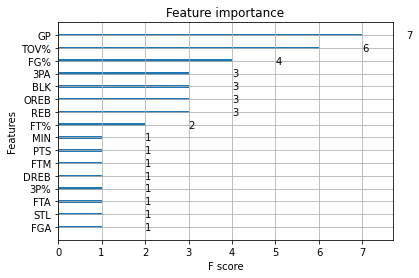

In [20]:
plot_importance(xgb_clf)
plt.show()

**Result:** Although TOV% is the 'most important' feature along with GP, adding it drops AUC slightly (-2.09%). PPG makes no difference to the score.

**Conclusion:** These variables add no value to model performance.

## **Experiment 2: XGBoost including Hyperparameter Tuning**

### **Define Train and Test Data**

In [21]:
train_data = pd.read_csv('/content/kaggle/train.csv')
test_data = pd.read_csv('/content/kaggle/test.csv')

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)

X_data, X_test, y_data, y_test = train_test_split(df_train_scaled, train_data_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

#### **Define Model**

In [22]:
xgb_clf = XGBClassifier(n_estimators=20, 
                            learning_rate=0.9, 
                            max_features=2, 
                            max_depth=2, 
                            random_state=42)

#### **Fit Model**

Train model using the train data set.

Score to beat (baseline model): 0.7223609643646144.

In [79]:
xgb_clf = XGBClassifier(learning_rate=0.9,
                        n_estimators=300,
                        max_depth=4,
                        colsample_bynode=1,
                        gamma=9,
                        max_delta_step=1,
                        min_child_weight=1, 
                        missing=None, 
                        n_jobs=1,
                        nthread=None, 
                        objective='binary:logistic', 
                        random_state=42,
                        reg_alpha=0, 
                        reg_lambda=0, 
                        scale_pos_weight=1, 
                        seed=None,
                        silent=True, subsample=1, verbosity=3)

xgb_clf.fit(X_train, 
            y_train,
            verbose=True,
            early_stopping_rounds = 10,
            eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])

[0]	validation_0-aucpr:0.858725
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.896031
[2]	validation_0-aucpr:0.908689
[3]	validation_0-aucpr:0.913744
[4]	validation_0-aucpr:0.914905
[5]	validation_0-aucpr:0.915303
[6]	validation_0-aucpr:0.915303
[7]	validation_0-aucpr:0.915303
[8]	validation_0-aucpr:0.915303
[9]	validation_0-aucpr:0.915303
[10]	validation_0-aucpr:0.915303
[11]	validation_0-aucpr:0.915303
[12]	validation_0-aucpr:0.915303
[13]	validation_0-aucpr:0.915303
[14]	validation_0-aucpr:0.915303
[15]	validation_0-aucpr:0.915303
Stopping. Best iteration:
[5]	validation_0-aucpr:0.915303



0.7255535582785607

### **Hyperparameter Tuning**

In [79]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

Define hyperparameter search space.

In [157]:
space = {
    'max_depth' : hp.choice('max_depth', range(5, 20, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.05),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.05),
    'gamma' : hp.quniform('gamma', 1, 10, 1),
    'n_estimators' : hp.quniform('n_estimators', 10, 1000, 1),
    'max_delta_step' : hp.quniform('max_delta_step', 0, 15, 1),
}

Instantiate a XGBClassifier with best set of hyperparameters

In [158]:
def objective(space):
    from sklearn.model_selection import cross_val_score
    
    xgboost = xgb.XGBClassifier(
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample'],
        colsample_bytree = space['colsample_bytree'],
        gamma = int(space['gamma']),
        n_estimators = int(space['n_estimators']),
        max_delta_step  = int(space['max_delta_step'])      
    )
    
    acc = cross_val_score(xgboost, X_train, y_train, cv=10, scoring="accuracy").mean()

    return{'loss': 1-acc, 'status': STATUS_OK }

Save optimal hyperparameters in best object.

In [159]:
best = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=5
)

100%|██████████| 5/5 [01:26<00:00, 17.29s/it, best loss: 0.17539062500000002]


In [160]:
print("Best: ", best)

Best:  {'colsample_bytree': 0.9500000000000001, 'gamma': 2.0, 'learning_rate': 0.25, 'max_delta_step': 11.0, 'max_depth': 2, 'min_child_weight': 8.0, 'n_estimators': 40.0, 'subsample': 0.8500000000000001}


In [174]:
xgboost2 = xgb.XGBClassifier(
    random_state=42,
    max_depth = best['max_depth'],
    learning_rate = best['learning_rate'],
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    gamma=best['gamma'],
    n_estimators=40

)

In [175]:
xgboost2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9500000000000001,
              gamma=2.0, learning_rate=0.25, max_delta_step=0, max_depth=2,
              min_child_weight=8.0, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8500000000000001, verbosity=1)

In [176]:
roc_auc_score(y_val, xgboost2.predict_proba(X_val)[:,1])

0.7162364897933047

**Result:** AUC 0.61% lower than the baseline.
**Conclusion:** The parameters qualitatively selected score a higher AUC score.

### **Experiment 3: Balance Data**

As is known, currently the 0:1 split is about 1:5. This section will look at the possible effects of this imbalance and try to correct it to achieve a superior outcome. This is the last of the experiments and it is hoped that the inbalance is the cause why other methods have not succeeded in yielding a better result.

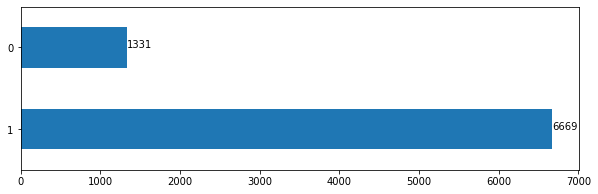

In [ ]:
# Check distribution balance of target variable
y = train_data.TARGET_5Yrs.value_counts()
fig= plt.figure(figsize=(10,3))
train_data.TARGET_5Yrs.value_counts().plot(kind='barh')
for index, value in enumerate(y):
    plt.text(value, index, str(value))
plt.show()

### **Confusion Matrix: Fit Model to Test data**

Fit model to test data to see how well it does with fresh data.

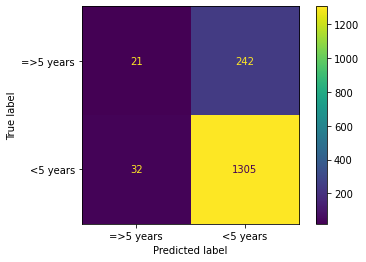

In [73]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xgb_clf,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["=>5 years","<5 years"])

**Conclusion:**
This is a fairly poor outcome (8.7% TP to FP). Looking at the FN:TN, which has performed inversely (97.5% TN:FN), I would assume this is an issue that may be addressed by balancing the data. 

### **Define Train and Test Data**

In [198]:
train_data = pd.read_csv('/content/kaggle/train.csv')
test_data = pd.read_csv('/content/kaggle/test.csv')

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = MinMaxScaler()
#df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)

X_data, X_test, y_data, y_test = train_test_split(df_train_scaled, train_data_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

#### **Define Model**

Changed scale_pos_weight to 5 as the ratio is 1:5 and this value is the inverse of the class distribution. That is sum(negative cases) / sum(positive cases) = 5.

In [211]:
xgb_clf1 = XGBClassifier( learning_rate=0.9,
                          random_state=42,
                          max_depth = best['max_depth'],
                          min_child_weight = best['min_child_weight'],
                          subsample = best['subsample'],
                          colsample_bytree = best['colsample_bytree'],
                          gamma=best['gamma'],
                          n_estimators=40,
                          scale_pos_weight=5
                          )

#### **Fit Model**

Train model using the train data set.

In [212]:
xgb_clf1.fit(X_train, 
            y_train,
            verbose=True,
            early_stopping_rounds = 10,
            eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

roc_auc_score(y_val, xgb_clf1.predict_proba(X_val)[:,1])

[0]	validation_0-aucpr:0.900853
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.901007
[2]	validation_0-aucpr:0.904152
[3]	validation_0-aucpr:0.913387
[4]	validation_0-aucpr:0.916735
[5]	validation_0-aucpr:0.916535
[6]	validation_0-aucpr:0.917999
[7]	validation_0-aucpr:0.91777
[8]	validation_0-aucpr:0.918139
[9]	validation_0-aucpr:0.915269
[10]	validation_0-aucpr:0.914128
[11]	validation_0-aucpr:0.914646
[12]	validation_0-aucpr:0.91432
[13]	validation_0-aucpr:0.915809
[14]	validation_0-aucpr:0.915045
[15]	validation_0-aucpr:0.912383
[16]	validation_0-aucpr:0.913438
[17]	validation_0-aucpr:0.915323
[18]	validation_0-aucpr:0.911468
Stopping. Best iteration:
[8]	validation_0-aucpr:0.918139



0.7121885734410949

#### **Confusion Matrix: Fit Model to Test data**

Fit model to test data to see how well it does with fresh data.

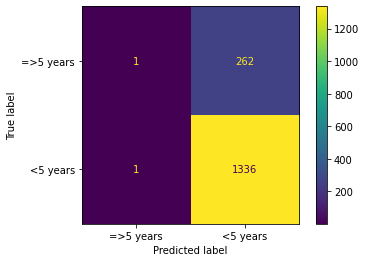

In [215]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xgb_clf1,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["=>5 years","<5 years"])

This is much worse than expected at estimating TP. Both the TP and AUC have decreased, although TN have increased. Surprising result and will have to go back to the drawing board to find more answers. More surprising is that the balanced data outputs obtained a better score on Kaggle than the non-balanced.

### **Export Best Probabilities**

In [219]:
submission = xgb_clf1.predict_proba(test_data_x)[:,1]
submission = pd.DataFrame({'Id':test_data['Id'], 'TARGET_5Yrs':submission})
submission.to_csv("/content/output/AdaBo ostClassifier_Predictions.csv", index=False)